In [1]:
import pandas as pd
from MatrixVectorizer import *
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


In [3]:
LR_size = 160
HR_size = 268

# Load Data

In [4]:
def antivectorize_df(adj_mtx_df, size):
    
    num_subject = adj_mtx_df.shape[0]
    adj_mtx = np.zeros((num_subject, size, size)) #torch.zeros((num_subject, LR_size, LR_size))
    for i in range(num_subject):
        adj_mtx[i] = MatrixVectorizer.anti_vectorize(adj_mtx_df.iloc[i], size) # torch.from_numpy(MatrixVectorizer.anti_vectorize(A_LR_train.iloc[i], LR_size))
    return adj_mtx


# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [5]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters

In [6]:
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model import *
from train import *
import argparse



epochs = 200


parser = argparse.ArgumentParser(description='GSR-Net')
parser.add_argument('--epochs', type=int, default=epochs, metavar='no_epochs',
                help='number of episode to train ')
parser.add_argument('--lr', type=float, default=0.0001, metavar='lr',
                help='learning rate (default: 0.0001 using Adam Optimizer)')
parser.add_argument('--splits', type=int, default=3, metavar='n_splits',
                help='no of cross validation folds')
parser.add_argument('--lmbda', type=int, default=16, metavar='L',
                help='self-reconstruction error hyperparameter')
parser.add_argument('--lr_dim', type=int, default=LR_size, metavar='N',
                help='adjacency matrix input dimensions')
parser.add_argument('--hr_dim', type=int, default=HR_size, metavar='N',
                help='super-resolved adjacency matrix output dimensions')
parser.add_argument('--hidden_dim', type=int, default=280, metavar='N',
                help='hidden GraphConvolutional layer dimensions')
parser.add_argument('--padding', type=int, default=26, metavar='padding',
                help='dimensions of padding')
# parser.add_argument('--padding', type=int, default=26, metavar='padding',
#                 help='dimensions of padding')
parser.add_argument('--embedding_size', type=int, default=32, metavar='embedding_size',
                help='node embedding size')
parser.add_argument('--early_stop_patient', type=int, default=3, metavar='early_stop_patient',
                help='early_stop_patience')

parser.add_argument('--mean_dense', type=float, default=0., metavar='mean',
                        help='mean of the normal distribution in Dense Layer')
parser.add_argument('--std_dense', type=float, default=0.01, metavar='std',
                    help='standard deviation of the normal distribution in Dense Layer')
parser.add_argument('--mean_gaussian', type=float, default=0., metavar='mean',
                    help='mean of the normal distribution in Gaussian Noise Layer')
parser.add_argument('--std_gaussian', type=float, default=0.1, metavar='std',
                    help='standard deviation of the normal distribution in Gaussian Noise Layer')



# Create an empty Namespace to hold the default arguments
args = parser.parse_args([]) 
print(args)

Namespace(epochs=200, lr=0.0001, splits=3, lmbda=16, lr_dim=160, hr_dim=268, hidden_dim=280, padding=26, embedding_size=32, early_stop_patient=3, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1)


In [7]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix #np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix #np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [8]:
device = get_device()
print(device)

cpu


# Normalization

In [9]:
def compute_degree_matrix_normalization_batch_numpy(adjacency_batch):
    """
    Optimizes the degree matrix normalization for a batch of adjacency matrices using NumPy.
    Computes the normalized adjacency matrix D^-1 * A for each graph in the batch.
    
    Parameters:
    - adjacency_batch: A NumPy array of shape (batch_size, num_nodes, num_nodes) representing
                       a batch of adjacency matrices.

    Returns:
    - A NumPy array of normalized adjacency matrices.
    """
    epsilon = 1e-6  # Small constant to avoid division by zero
    # Calculate the degree for each node in the batch
    d = adjacency_batch.sum(axis=2) + epsilon
    
    # Compute the inverse degree matrix D^-1 for the batch
    D_inv = np.reciprocal(d)[:, :, np.newaxis] * np.eye(adjacency_batch.shape[1])[np.newaxis, :, :]
    
    # Normalize the adjacency matrix using batch matrix multiplication
    normalized_adjacency_batch = np.matmul(D_inv, adjacency_batch)
    
    return normalized_adjacency_batch

def symmetric_nodem(A):
    num_samples = A.shape[0]  # Number of samples, i.e., slices in the 3D tensor

    # Initialize an empty array for the normalized matrices
    A_normalized = np.zeros_like(A)

    for i in range(num_samples):
        # Extract the i-th adjacency matrix
        Ai = A[i, :, :]
        
        # Compute the degree matrix D and its inverse square root for Ai
        Di = np.diag(np.sum(Ai, axis=1))
        D_inv_sqrt_i = np.linalg.inv(np.sqrt(Di))
        
        # Normalize the adjacency matrix
        A_normalized[i, :, :] = D_inv_sqrt_i @ Ai @ D_inv_sqrt_i
    return A_normalized

X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)
print(X.shape)

(167, 160, 160)


# K-Fold cross validation

In [10]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

ks = [0.9, 0.7, 0.6, 0.5, 0.2]

best_model_fold_list = []
data_fold_list = []
i = 1
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
        train_index], X[test_index], Y[train_index], Y[test_index]
    data_fold_list.append((subjects_adj, test_adj, subjects_ground_truth, test_ground_truth))


    netG = GSRNet(ks, args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    return_model = train_gan(
        netG, 
        optimizerG, 
        netD,
        optimizerD,
        subjects_adj, 
        subjects_ground_truth, 
        args, 
        test_adj=test_adj, 
        test_ground_truth=test_ground_truth
    )

    # return_model = train(netG, optimizerG, subjects_adj, subjects_ground_truth, args, test_adj, test_ground_truth)
    test_mae = test(return_model, test_adj, test_ground_truth, args)
    print(f"Val MAE: {test_mae}")
    best_model_fold_list.append(return_model)

    i += 1

----- Fold 1 -----


Epoch Progress:   0%|          | 1/200 [00:26<1:26:18, 26.02s/epoch]

Epoch: 1, Train Loss: 1.909374, Train Error: 0.250862, Test Error: 0.221545


Epoch Progress:   1%|          | 2/200 [00:53<1:28:56, 26.95s/epoch]

Epoch: 2, Train Loss: 2.298057, Train Error: 0.193453, Test Error: 0.168361


Epoch Progress:   2%|▏         | 3/200 [01:19<1:26:51, 26.45s/epoch]

Epoch: 3, Train Loss: 3.164878, Train Error: 0.176998, Test Error: 0.166330


Epoch Progress:   2%|▏         | 4/200 [01:45<1:25:29, 26.17s/epoch]

Epoch: 4, Train Loss: 3.915996, Train Error: 0.175430, Test Error: 0.165728


Epoch Progress:   2%|▎         | 5/200 [02:13<1:27:04, 26.79s/epoch]

Epoch: 5, Train Loss: 4.589886, Train Error: 0.174574, Test Error: 0.165170


Epoch Progress:   3%|▎         | 6/200 [02:42<1:29:37, 27.72s/epoch]

Epoch: 6, Train Loss: 5.128133, Train Error: 0.173845, Test Error: 0.164503


Epoch Progress:   4%|▎         | 7/200 [03:11<1:30:11, 28.04s/epoch]

Epoch: 7, Train Loss: 5.511898, Train Error: 0.172986, Test Error: 0.163702


Epoch Progress:   4%|▍         | 8/200 [03:35<1:26:09, 26.93s/epoch]

Epoch: 8, Train Loss: 5.758876, Train Error: 0.171997, Test Error: 0.162898


Epoch Progress:   4%|▍         | 9/200 [04:00<1:23:11, 26.14s/epoch]

Epoch: 9, Train Loss: 5.925265, Train Error: 0.170920, Test Error: 0.161838


Epoch Progress:   5%|▌         | 10/200 [04:27<1:24:14, 26.60s/epoch]

Epoch: 10, Train Loss: 5.987227, Train Error: 0.169647, Test Error: 0.160573


Epoch Progress:   6%|▌         | 11/200 [04:54<1:23:43, 26.58s/epoch]

Epoch: 11, Train Loss: 6.023181, Train Error: 0.168184, Test Error: 0.159241


Epoch Progress:   6%|▌         | 12/200 [05:20<1:22:19, 26.27s/epoch]

Epoch: 12, Train Loss: 6.022675, Train Error: 0.166702, Test Error: 0.157788


Epoch Progress:   6%|▋         | 13/200 [05:45<1:21:36, 26.18s/epoch]

Epoch: 13, Train Loss: 6.010212, Train Error: 0.165145, Test Error: 0.156300


Epoch Progress:   7%|▋         | 14/200 [06:10<1:19:42, 25.71s/epoch]

Epoch: 14, Train Loss: 5.993036, Train Error: 0.163637, Test Error: 0.154867


Epoch Progress:   8%|▊         | 15/200 [06:35<1:18:23, 25.42s/epoch]

Epoch: 15, Train Loss: 5.960486, Train Error: 0.162098, Test Error: 0.153488


Epoch Progress:   8%|▊         | 16/200 [06:59<1:17:07, 25.15s/epoch]

Epoch: 16, Train Loss: 5.952407, Train Error: 0.160616, Test Error: 0.151952


Epoch Progress:   8%|▊         | 17/200 [07:24<1:16:24, 25.05s/epoch]

Epoch: 17, Train Loss: 5.899797, Train Error: 0.159047, Test Error: 0.150756


Epoch Progress:   9%|▉         | 18/200 [07:50<1:16:25, 25.19s/epoch]

Epoch: 18, Train Loss: 5.884411, Train Error: 0.157730, Test Error: 0.149595


Epoch Progress:  10%|▉         | 19/200 [08:15<1:15:40, 25.09s/epoch]

Epoch: 19, Train Loss: 5.943938, Train Error: 0.156407, Test Error: 0.148114


Epoch Progress:  10%|█         | 20/200 [08:40<1:15:28, 25.16s/epoch]

Epoch: 20, Train Loss: 5.994504, Train Error: 0.155078, Test Error: 0.147155


Epoch Progress:  10%|█         | 21/200 [09:04<1:14:08, 24.85s/epoch]

Epoch: 21, Train Loss: 6.077084, Train Error: 0.153855, Test Error: 0.146161


Epoch Progress:  11%|█         | 22/200 [09:28<1:12:55, 24.58s/epoch]

Epoch: 22, Train Loss: 6.137840, Train Error: 0.152788, Test Error: 0.145246


Epoch Progress:  12%|█▏        | 23/200 [09:52<1:11:59, 24.41s/epoch]

Epoch: 23, Train Loss: 6.275723, Train Error: 0.151717, Test Error: 0.144332


Epoch Progress:  12%|█▏        | 24/200 [10:18<1:12:35, 24.75s/epoch]

Epoch: 24, Train Loss: 6.391701, Train Error: 0.150709, Test Error: 0.143566


Epoch Progress:  12%|█▎        | 25/200 [10:46<1:15:42, 25.96s/epoch]

Epoch: 25, Train Loss: 6.456587, Train Error: 0.149754, Test Error: 0.143031


Epoch Progress:  13%|█▎        | 26/200 [11:11<1:13:47, 25.44s/epoch]

Epoch: 26, Train Loss: 6.610936, Train Error: 0.148876, Test Error: 0.142384


Epoch Progress:  14%|█▎        | 27/200 [11:35<1:12:20, 25.09s/epoch]

Epoch: 27, Train Loss: 6.722321, Train Error: 0.148030, Test Error: 0.141863


Epoch Progress:  14%|█▍        | 28/200 [12:00<1:11:41, 25.01s/epoch]

Epoch: 28, Train Loss: 6.853661, Train Error: 0.147276, Test Error: 0.141350


Epoch Progress:  14%|█▍        | 29/200 [12:27<1:12:53, 25.57s/epoch]

Epoch: 29, Train Loss: 7.014800, Train Error: 0.146539, Test Error: 0.140679


Epoch Progress:  15%|█▌        | 30/200 [12:53<1:12:51, 25.71s/epoch]

Epoch: 30, Train Loss: 7.201234, Train Error: 0.145853, Test Error: 0.140077


Epoch Progress:  16%|█▌        | 31/200 [13:17<1:11:40, 25.45s/epoch]

Epoch: 31, Train Loss: 7.421155, Train Error: 0.145202, Test Error: 0.139850


Epoch Progress:  16%|█▌        | 32/200 [13:45<1:12:43, 25.97s/epoch]

Epoch: 32, Train Loss: 7.604531, Train Error: 0.144628, Test Error: 0.139099


Epoch Progress:  16%|█▋        | 33/200 [14:13<1:14:34, 26.80s/epoch]

Epoch: 33, Train Loss: 7.832336, Train Error: 0.144046, Test Error: 0.138453


Epoch Progress:  17%|█▋        | 34/200 [14:38<1:12:45, 26.30s/epoch]

Epoch: 34, Train Loss: 8.065297, Train Error: 0.143489, Test Error: 0.137894


Epoch Progress:  18%|█▊        | 35/200 [15:05<1:12:20, 26.31s/epoch]

Epoch: 35, Train Loss: 8.274629, Train Error: 0.142918, Test Error: 0.137437


Epoch Progress:  18%|█▊        | 36/200 [15:30<1:11:21, 26.11s/epoch]

Epoch: 36, Train Loss: 8.469720, Train Error: 0.142379, Test Error: 0.136981


Epoch Progress:  18%|█▊        | 37/200 [15:55<1:10:02, 25.78s/epoch]

Epoch: 37, Train Loss: 8.663141, Train Error: 0.141885, Test Error: 0.136946


Epoch Progress:  19%|█▉        | 38/200 [16:22<1:09:55, 25.90s/epoch]

Epoch: 38, Train Loss: 8.979291, Train Error: 0.141472, Test Error: 0.136948


Epoch Progress:  20%|█▉        | 39/200 [16:47<1:09:19, 25.84s/epoch]

Epoch: 39, Train Loss: 9.215841, Train Error: 0.141020, Test Error: 0.136542


Epoch Progress:  20%|██        | 40/200 [17:13<1:08:33, 25.71s/epoch]

Epoch: 40, Train Loss: 9.461487, Train Error: 0.140586, Test Error: 0.136052


Epoch Progress:  20%|██        | 41/200 [17:39<1:08:27, 25.84s/epoch]

Epoch: 41, Train Loss: 9.639176, Train Error: 0.140202, Test Error: 0.135794


Epoch Progress:  21%|██        | 42/200 [18:04<1:07:36, 25.67s/epoch]

Epoch: 42, Train Loss: 9.806147, Train Error: 0.139726, Test Error: 0.135563


Epoch Progress:  22%|██▏       | 43/200 [18:29<1:06:35, 25.45s/epoch]

Epoch: 43, Train Loss: 9.947242, Train Error: 0.139286, Test Error: 0.135374


Epoch Progress:  22%|██▏       | 44/200 [18:55<1:06:24, 25.54s/epoch]

Epoch: 44, Train Loss: 10.108888, Train Error: 0.138884, Test Error: 0.135193


Epoch Progress:  22%|██▎       | 45/200 [19:24<1:08:58, 26.70s/epoch]

Epoch: 45, Train Loss: 10.266486, Train Error: 0.138564, Test Error: 0.135105


Epoch Progress:  23%|██▎       | 46/200 [19:50<1:07:44, 26.39s/epoch]

Epoch: 46, Train Loss: 10.464251, Train Error: 0.138269, Test Error: 0.134789


Epoch Progress:  24%|██▎       | 47/200 [20:19<1:09:02, 27.08s/epoch]

Epoch: 47, Train Loss: 10.678969, Train Error: 0.138243, Test Error: 0.134903


Epoch Progress:  24%|██▍       | 48/200 [20:47<1:09:38, 27.49s/epoch]

Epoch: 48, Train Loss: 10.913661, Train Error: 0.138068, Test Error: 0.135001


In [92]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

def evaluate(pred_matrices, gt_matrices, cal_graph=False):

    # pred_matrices = pred_matrices.cpu().detach().numpy()
    # gt_matrices = gt_matrices.cpu().detach().numpy()

    num_test_samples = gt_matrices.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []
    
    pred_1d = []
    gt_1d = []

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):

        pred_1d.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d.append(MatrixVectorizer.vectorize(gt_matrices[i]))

        if cal_graph:
            # Convert adjacency matrices to NetworkX graphs
            pred_graph = nx.from_numpy_array(pred_matrices[i])
            gt_graph = nx.from_numpy_array(gt_matrices[i])

            # Compute centrality measures
            pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
            pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
            pred_pc = nx.pagerank(pred_graph, weight="weight")

            gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
            gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
            gt_pc = nx.pagerank(gt_graph, weight="weight")

            # Convert centrality dictionaries to lists
            pred_bc_values = list(pred_bc.values())
            pred_ec_values = list(pred_ec.values())
            pred_pc_values = list(pred_pc.values())

            gt_bc_values = list(gt_bc.values())
            gt_ec_values = list(gt_ec.values())
            gt_pc_values = list(gt_pc.values())

            # Compute MAEs
            mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
            mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
            mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    if cal_graph:
        # Compute average MAEs
        avg_mae_bc = sum(mae_bc) / len(mae_bc)
        avg_mae_ec = sum(mae_ec) / len(mae_ec)
        avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # vectorize and flatten
    pred_1d = np.concatenate(pred_1d, axis=0).flatten()
    gt_1d = np.concatenate(gt_1d, axis=0).flatten()

    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    if cal_graph:
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    if cal_graph:

        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            "MAE_(BC)": avg_mae_bc,
            "MAE_(EC)": avg_mae_ec,
            "MAE_(PC)": avg_mae_pc
        }
    else:
        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            # "MAE_(BC)": avg_mae_bc,
            # "MAE_(EC)": avg_mae_ec,
            # "MAE_(PC)": avg_mae_pc
        }

    return res



In [93]:
res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=False))

pd.DataFrame(res_list)

100%|██████████| 56/56 [00:00<00:00, 81.01it/s]


MAE:  0.1343036041764756
PCC:  0.6310622563904384
Jensen-Shannon Distance:  0.2857619928866324


100%|██████████| 56/56 [00:00<00:00, 75.86it/s]


MAE:  0.14301409711826155
PCC:  0.6057289905216237
Jensen-Shannon Distance:  0.29781165282880895


100%|██████████| 55/55 [00:00<00:00, 76.12it/s]


MAE:  0.14027413385910412
PCC:  0.6080395047059572
Jensen-Shannon Distance:  0.2912650995086628


,MAE,PCC,JSD
0,0.134304,0.631062,0.285762
1,0.143014,0.605729,0.297812
2,0.140274,0.608040,0.291265


In [33]:
# res_list = []

# for i in range(args.splits):
#     _, test_adjs, _, gt_matrices = data_fold_list[i]
#     model = best_model_fold_list[i]
#     model.eval()
#     pred_matrices = np.zeros(gt_matrices.shape)
#     with torch.no_grad():
#         for j, test_adj in enumerate(test_adjs):
#             pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
#     res_list.append(evaluate(pred_matrices, gt_matrices))

100%|██████████| 56/56 [07:54<00:00,  8.48s/it]


MAE:  0.1337221793821569
PCC:  0.6690317113475489
Jensen-Shannon Distance:  0.28160411074519315
Average MAE betweenness centrality: 0.020928027181463155
Average MAE eigenvector centrality: 0.012598842558915193
Average MAE PageRank centrality: 0.0005571221999112931


100%|██████████| 56/56 [07:27<00:00,  7.99s/it]


MAE:  0.14377453968697707
PCC:  0.6368867678033938
Jensen-Shannon Distance:  0.2941316276366009
Average MAE betweenness centrality: 0.021267155259678393
Average MAE eigenvector centrality: 0.01280246484848338
Average MAE PageRank centrality: 0.0005505529555365447


100%|██████████| 55/55 [07:28<00:00,  8.15s/it]

MAE:  0.14358360996777259
PCC:  0.6280176357506309
Jensen-Shannon Distance:  0.28623036397916884
Average MAE betweenness centrality: 0.021948556693519042
Average MAE eigenvector centrality: 0.012785476974878968
Average MAE PageRank centrality: 0.000579433557870767


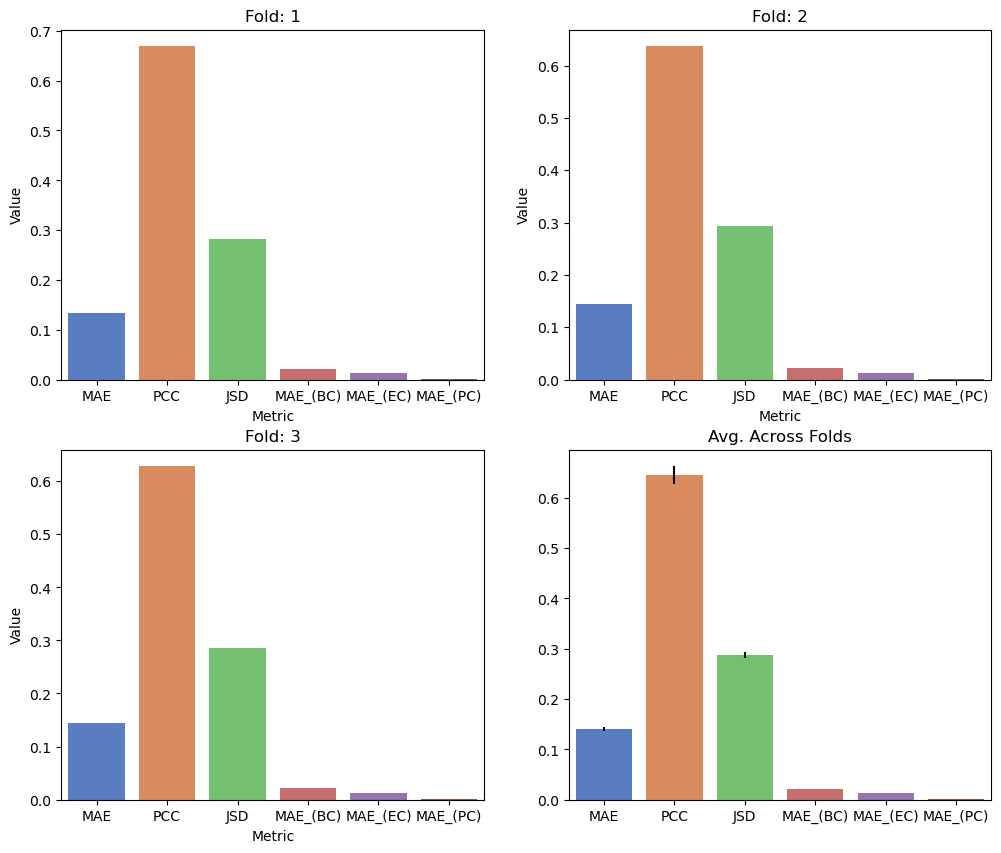

In [88]:
def plot_metrics_fold(res_list):
    df = pd.DataFrame(res_list)
    df = df.rename(columns={"mae": "MAE", "pcc": "PCC", "js_dis": "JSD", "avg_mae_bc": "MAE_(BC)", "avg_mae_ec": "MAE_(EC)", "avg_mae_pc": "MAE_(PC)"})
    df.index = df.index.set_names(['Fold'])
    df.loc['mean'] = df.mean()
    avg_data = df.iloc[-1, :]
    df.loc['std'] = df.std()
    errors = df.iloc[-1, :].tolist()
    df = df.reset_index()
    df = df.iloc[:-2, :]
    df_long = df.melt(id_vars='Fold', var_name='Metric', value_name='Value')
    palette = sns.color_palette("muted", n_colors=len(df_long['Metric'].unique()))
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for fold in range(3):   
        i = fold // 2
        j = fold % 2
        sns.barplot(x='Metric', y='Value', data=df_long[df_long['Fold'] == fold], ax=axs[i, j], palette=palette)
        axs[i, j].set_title(f"Fold: {fold+1}")

    sns.barplot(x=avg_data.index, y=avg_data.values, ax=axs[1, 1], palette=palette, yerr=errors, capsize=5)
    axs[1, 1].set_title("Avg. Across Folds")
    plt.show()

plot_metrics_fold(res_list)


# Split train and validation

In [13]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(A_HR_train_pca.shape)

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load('A_LR_train_matrix.npy')
y = np.load('A_HR_train_matrix.npy')

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1), 
    y.reshape(n_sample, -1), 
    test_size=0.20, 
    random_state=random_seed,
    stratify=A_HR_train_label
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))



(167, 161)
[[ 0 14]
 [ 1 30]
 [ 2 30]
 [ 3 46]
 [ 4 47]]
Train size: 133
Val size: 34


# Train Final Model

In [14]:
netG = GSRNet(ks, args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

final_model = train_gan(
    netG, 
    optimizerG, 
    netD,
    optimizerD,
    X_train, 
    y_train, 
    args, 
    test_adj=X_val, 
    test_ground_truth=y_val
)
# final_model = train(netG, optimizerG, X_train, y_train, args, X_val, y_val)

Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 1/200 [00:26<1:27:50, 26.49s/epoch]

Epoch: 1, Train Loss: 2.023875, Train Error: 0.246109, Test Error: 0.214552


Epoch Progress:   1%|          | 2/200 [00:53<1:29:17, 27.06s/epoch]

Epoch: 2, Train Loss: 2.414312, Train Error: 0.184230, Test Error: 0.169388


Epoch Progress:   2%|▏         | 3/200 [01:22<1:31:47, 27.96s/epoch]

Epoch: 3, Train Loss: 3.492870, Train Error: 0.174615, Test Error: 0.168158


Epoch Progress:   2%|▏         | 4/200 [01:50<1:30:35, 27.73s/epoch]

Epoch: 4, Train Loss: 4.350230, Train Error: 0.173600, Test Error: 0.167503


Epoch Progress:   2%|▎         | 5/200 [02:17<1:29:52, 27.66s/epoch]

Epoch: 5, Train Loss: 5.026290, Train Error: 0.172799, Test Error: 0.166740


Epoch Progress:   3%|▎         | 6/200 [02:43<1:27:41, 27.12s/epoch]

Epoch: 6, Train Loss: 5.488374, Train Error: 0.171931, Test Error: 0.166027


Epoch Progress:   4%|▎         | 7/200 [03:10<1:26:15, 26.82s/epoch]

Epoch: 7, Train Loss: 5.784516, Train Error: 0.170924, Test Error: 0.164946


Epoch Progress:   4%|▍         | 8/200 [03:37<1:26:08, 26.92s/epoch]

Epoch: 8, Train Loss: 5.930690, Train Error: 0.169634, Test Error: 0.163561


Epoch Progress:   4%|▍         | 9/200 [04:03<1:24:52, 26.66s/epoch]

Epoch: 9, Train Loss: 6.071169, Train Error: 0.167955, Test Error: 0.161598


Epoch Progress:   5%|▌         | 10/200 [04:29<1:24:04, 26.55s/epoch]

Epoch: 10, Train Loss: 6.119112, Train Error: 0.165761, Test Error: 0.159212


Epoch Progress:   6%|▌         | 11/200 [05:00<1:27:22, 27.74s/epoch]

Epoch: 11, Train Loss: 6.112508, Train Error: 0.163287, Test Error: 0.156630


Epoch Progress:   6%|▌         | 12/200 [05:26<1:25:39, 27.34s/epoch]

Epoch: 12, Train Loss: 6.070328, Train Error: 0.160897, Test Error: 0.154057


Epoch Progress:   6%|▋         | 13/200 [05:53<1:24:26, 27.09s/epoch]

Epoch: 13, Train Loss: 6.087673, Train Error: 0.158530, Test Error: 0.152158


Epoch Progress:   7%|▋         | 14/200 [06:19<1:23:49, 27.04s/epoch]

Epoch: 14, Train Loss: 6.102086, Train Error: 0.156615, Test Error: 0.150223


Epoch Progress:   8%|▊         | 15/200 [06:47<1:23:30, 27.08s/epoch]

Epoch: 15, Train Loss: 6.142952, Train Error: 0.154862, Test Error: 0.148491


Epoch Progress:   8%|▊         | 16/200 [07:13<1:22:29, 26.90s/epoch]

Epoch: 16, Train Loss: 6.245514, Train Error: 0.153333, Test Error: 0.147355


Epoch Progress:   8%|▊         | 17/200 [07:40<1:21:58, 26.88s/epoch]

Epoch: 17, Train Loss: 6.355291, Train Error: 0.151928, Test Error: 0.145985


Epoch Progress:   9%|▉         | 18/200 [08:06<1:21:08, 26.75s/epoch]

Epoch: 18, Train Loss: 6.550700, Train Error: 0.150726, Test Error: 0.144965


Epoch Progress:  10%|▉         | 19/200 [08:33<1:20:39, 26.74s/epoch]

Epoch: 19, Train Loss: 6.713019, Train Error: 0.149540, Test Error: 0.143922


Epoch Progress:  10%|█         | 20/200 [09:00<1:19:59, 26.67s/epoch]

Epoch: 20, Train Loss: 6.929258, Train Error: 0.148407, Test Error: 0.143182


Epoch Progress:  10%|█         | 21/200 [09:27<1:19:44, 26.73s/epoch]

Epoch: 21, Train Loss: 7.132182, Train Error: 0.147524, Test Error: 0.142391


Epoch Progress:  11%|█         | 22/200 [09:53<1:19:13, 26.70s/epoch]

Epoch: 22, Train Loss: 7.422778, Train Error: 0.146649, Test Error: 0.141669


Epoch Progress:  12%|█▏        | 23/200 [10:20<1:18:59, 26.77s/epoch]

Epoch: 23, Train Loss: 7.797724, Train Error: 0.145883, Test Error: 0.140802


Epoch Progress:  12%|█▏        | 24/200 [10:47<1:18:57, 26.92s/epoch]

Epoch: 24, Train Loss: 8.253225, Train Error: 0.145115, Test Error: 0.140395


Epoch Progress:  12%|█▎        | 25/200 [11:14<1:18:12, 26.81s/epoch]

Epoch: 25, Train Loss: 8.603925, Train Error: 0.144467, Test Error: 0.139784


Epoch Progress:  13%|█▎        | 26/200 [11:41<1:17:54, 26.87s/epoch]

Epoch: 26, Train Loss: 9.058057, Train Error: 0.143782, Test Error: 0.139194


Epoch Progress:  14%|█▎        | 27/200 [12:09<1:18:46, 27.32s/epoch]

Epoch: 27, Train Loss: 9.468748, Train Error: 0.143048, Test Error: 0.138739


Epoch Progress:  14%|█▍        | 28/200 [12:35<1:17:07, 26.90s/epoch]

Epoch: 28, Train Loss: 9.884005, Train Error: 0.142446, Test Error: 0.138083


Epoch Progress:  14%|█▍        | 29/200 [13:01<1:15:42, 26.57s/epoch]

Epoch: 29, Train Loss: 10.219618, Train Error: 0.141901, Test Error: 0.137680


Epoch Progress:  15%|█▌        | 30/200 [13:27<1:14:47, 26.40s/epoch]

Epoch: 30, Train Loss: 10.524211, Train Error: 0.141393, Test Error: 0.137385


Epoch Progress:  16%|█▌        | 31/200 [13:54<1:15:13, 26.71s/epoch]

Epoch: 31, Train Loss: 10.874853, Train Error: 0.140967, Test Error: 0.137020


Epoch Progress:  16%|█▌        | 32/200 [14:21<1:14:21, 26.56s/epoch]

Epoch: 32, Train Loss: 11.208862, Train Error: 0.140628, Test Error: 0.136728


Epoch Progress:  16%|█▋        | 33/200 [14:47<1:13:26, 26.38s/epoch]

Epoch: 33, Train Loss: 11.634868, Train Error: 0.140185, Test Error: 0.136325


Epoch Progress:  17%|█▋        | 34/200 [15:13<1:13:02, 26.40s/epoch]

Epoch: 34, Train Loss: 11.954612, Train Error: 0.139801, Test Error: 0.136059


Epoch Progress:  18%|█▊        | 35/200 [15:40<1:12:49, 26.48s/epoch]

Epoch: 35, Train Loss: 12.274712, Train Error: 0.139512, Test Error: 0.135896


Epoch Progress:  18%|█▊        | 36/200 [16:06<1:12:08, 26.39s/epoch]

Epoch: 36, Train Loss: 12.462278, Train Error: 0.139195, Test Error: 0.136039


Epoch Progress:  18%|█▊        | 37/200 [16:33<1:12:27, 26.67s/epoch]

Epoch: 37, Train Loss: 12.754637, Train Error: 0.138977, Test Error: 0.136175


Epoch Progress:  19%|█▉        | 38/200 [17:00<1:11:52, 26.62s/epoch]

Epoch: 38, Train Loss: 13.112604, Train Error: 0.138541, Test Error: 0.135931


Epoch Progress:  20%|█▉        | 39/200 [17:26<1:11:28, 26.64s/epoch]

Epoch: 39, Train Loss: 13.423132, Train Error: 0.138117, Test Error: 0.135578


Epoch Progress:  20%|██        | 40/200 [17:52<1:10:29, 26.43s/epoch]

Epoch: 40, Train Loss: 13.715359, Train Error: 0.137827, Test Error: 0.135187


Epoch Progress:  20%|██        | 41/200 [18:18<1:09:45, 26.32s/epoch]

Epoch: 41, Train Loss: 13.863079, Train Error: 0.137576, Test Error: 0.134791


Epoch Progress:  21%|██        | 42/200 [18:44<1:08:57, 26.18s/epoch]

Epoch: 42, Train Loss: 13.962252, Train Error: 0.137235, Test Error: 0.134544


Epoch Progress:  22%|██▏       | 43/200 [19:11<1:08:54, 26.33s/epoch]

Epoch: 43, Train Loss: 14.087437, Train Error: 0.137018, Test Error: 0.134329


Epoch Progress:  22%|██▏       | 44/200 [19:37<1:08:34, 26.37s/epoch]

Epoch: 44, Train Loss: 14.225527, Train Error: 0.136764, Test Error: 0.134430


Epoch Progress:  22%|██▎       | 45/200 [20:03<1:07:47, 26.24s/epoch]

Epoch: 45, Train Loss: 14.507247, Train Error: 0.136489, Test Error: 0.134499


Epoch Progress:  23%|██▎       | 46/200 [20:30<1:07:33, 26.32s/epoch]

Epoch: 46, Train Loss: 14.663796, Train Error: 0.136374, Test Error: 0.134747


Epoch Progress:  23%|██▎       | 46/200 [21:00<1:10:18, 27.39s/epoch]

Val Error: 0.134329


In [94]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred_train_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred_val_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Val")
    evaluate(pred_val_matrices, y_val)

Train


100%|██████████| 133/133 [00:01<00:00, 74.18it/s]


MAE:  0.13347821198387197
PCC:  0.6473332777405999
Jensen-Shannon Distance:  0.2845259154453596
Val


100%|██████████| 34/34 [00:00<00:00, 76.46it/s]

MAE:  0.13483210523065542
PCC:  0.641056448278343
Jensen-Shannon Distance:  0.28003819570731714


# Predict Test Set

In [20]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in range(A_LR_test_matrix.shape[0]):
        output_pred, _, _, _ = final_model(torch.Tensor(A_LR_test_matrix[i]))
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

In [21]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136, )

In [22]:
df = pd.DataFrame({
    "ID": [i+1 for i in range(len(output_pred_1d))],
    "Predicted": output_pred_1d.tolist()
})

df

,ID,Predicted
0,1,0.506379
1,2,0.544307
2,3,0.615777
3,4,0.468869
4,5,0.431444
...,...,...
4007131,4007132,0.038365
4007132,4007133,0.000000
4007133,4007134,0.241379
4007134,4007135,0.177764


In [23]:
df.to_csv("gsr_gan_gat_relu.csv", index=False)